# Ventral Decoding on Word Identification

In [1]:
#Load the required libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Model,load_model
from keras import backend as K
from keras import models, layers
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
import re
import json
import seaborn as sns

from IPython.display import display, HTML
from pdb import set_trace

%matplotlib inline
sns.set()

## Data Preprocessing

In [2]:
#create dicts from csv
##------------------------------ Dataset -------------------------------------##
import csv
import threading


#csv.field_size_limit(10**7)

def read_dict(path):
    'Reads Python dictionary stored in a csv file'
    dictionary = {}
    for key, val in csv.reader(open(path)):
        dictionary[key] = val
    return dictionary

# Load partitions
partition = read_dict('/PATH/dicts/partition.csv')

def read_patterns(csv_file):
    '''
    Reads in target patterns of the form:
        label,v1,v2,...,vN
    '''
    pattern_dict = {}
    with open(csv_file,'r') as f:
        for line in f:
            atoms = line.strip().split(',')
            word = atoms[0]
            pattern = np.array([float(x) for x in atoms[1:]])
            pattern_dict[word] = pattern
    return pattern_dict

# Load dictionary of labels
labels = read_patterns('/PATH/dicts/labels_dorsalsoftmax.csv')
#print(labels)


exec("partition['train'] = " + partition['train'])
exec("partition['validation'] = " + partition['validation'])
exec("partition['test'] = " + partition['test'])

# # Final computations
# partition['train'] = partition['train'] 
# partition['validation'] = partition['validation']
# partition['test'] = partition['test']

partition['full'] = partition['train'] + partition['validation'] + partition['test']
partition['train'] = partition['train'] + partition['validation']
partition['validation'] = partition['test']

In [3]:
#Define the Data Generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    my_list = [] #global variable for getting the IDs
    my_labels = [] #global variable for getting the labels
    def __init__(self, list_IDs, labels, batch_size=8800, dim=(226,211), #n_channels=1,
                 n_classes=883, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.my_list = []
        self.my_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # FA and NS added this part to get the names of the words
        if index == 0:
            indexes2 = self.indexes[index*8800:(index+1)*8800] #7900 become 800 for the val data
            list_IDs_temp2 = [self.list_IDs[k] for k in indexes2]
            self.my_list = list_IDs_temp2 # This is for getting shuffled list_IDs for get_my_list
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        #check shape
        #print('X : shape = %s, type = %s' % (X.shape, X.dtype) ) # If np.array
        #print('y : shape = %s, type = %s' % (y.shape, y.dtype) )

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        y = np.empty((self.batch_size, 226)) #226 is the max len here
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('/PATH/Cochs/' + ID + '.npy') #data1 for the toy

            # Store class
            y[i] = self.labels[ID]
        
        self.my_labels = y
       
        return X, y#keras.utils.to_categorical(y, num_classes=self.n_classes)

In [4]:
# Parameters for the Data Generator
params = {'dim': (226,211),
          'batch_size': 8800,
          'n_classes': 883,
          #'n_channels': 1,
          'shuffle': True}

# Datasets
partition = partition
labels = labels

# Generators
full_generator = DataGenerator(partition['full'], labels, **params)
training_generator = DataGenerator(partition['train'], labels, **params) #9 token per word
validation_generator = DataGenerator(partition['validation'], labels, **params) #1 token per word

In [5]:
#Load the model and chose the penultimate layer
import tensorflow as tf

model = tf.keras.models.load_model('/bestventralmodel.hd5f')
#model.summary()
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer('lstm').output)
intermediate_layer_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_input (InputLayer)   [(None, 226, 211)]        0         
_________________________________________________________________
masking (Masking)            (None, 226, 211)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 226, 512)          1482752   
Total params: 1,482,752
Trainable params: 1,482,752
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Get the features from the model for the test data
features = intermediate_layer_model.predict(full_generator, verbose=0)
print(features.shape)
features = features[:,0:225,:] #to choose the features from the first 25 time slices
features = features.reshape(8800,225*512) # reshape so that 3D to 2D
print(features.shape)

(8800, 226, 512)
(8800, 115200)


In [7]:
#Get the labels from the Data Generator
y = full_generator.my_labels[:,0]
y = np.array(y, dtype='int64')
print(y.shape)

(8800,)


In [9]:
#put the features to a data frame
data = pd.DataFrame(features) #X_new if you do feature selection
#data.head()

#Get word IDs from the Data Generator
data = pd.DataFrame(data, columns=data.columns, index=data.index)
data['Words'] = np.array(full_generator.my_list)
data = data.set_index('Words')

#Get the labels from the Data Generator
#data['Labels'] = test_generator.my_labels[:,0]

#save the data frame and look at the data
#data.to_csv('/autofs/space/euler_001/users/lstm/data.csv')
data.head

<bound method NDFrame.head of                      0         1         2         3         4         5       \
Words                                                                           
manageable-Ralph  -0.068619 -0.111282 -0.059904  0.058313 -0.041318  0.076464   
brighter-Victoria -0.067807 -0.119974 -0.058308  0.118921 -0.049889  0.073252   
translating-Kathy -0.066904 -0.136812 -0.058333  0.141141 -0.072255  0.059648   
actively-Agnes    -0.046013 -0.100297 -0.065350  0.105203 -0.050373  0.123309   
passing-Alex      -0.068847 -0.121579 -0.059501  0.100459 -0.051285  0.075059   
...                     ...       ...       ...       ...       ...       ...   
power-Ralph       -0.048432 -0.120747 -0.076070  0.159697 -0.065651  0.116017   
slowness-Fred     -0.086446 -0.072607 -0.027685  0.056083 -0.027757  0.030388   
cooker-Bruce      -0.068661 -0.119085 -0.064866  0.124824 -0.053582  0.090187   
taking-Bruce      -0.076509 -0.144568 -0.038034  0.140324 -0.060854  0.052830  

# Steps to Clustering

## PCA for Just Visual

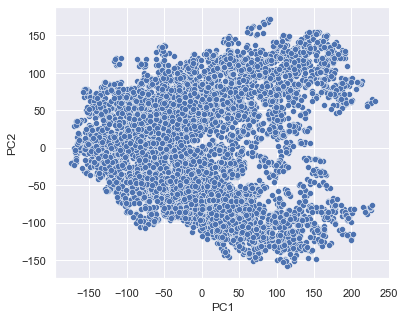

In [11]:
#Scaling and Dimensionality Reduction
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline(steps=[
  ('scaler', StandardScaler(with_mean=False)),
  ('dim_reduction', PCA(n_components=2, random_state=0))
])

pc = pipeline.fit_transform(data)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=pc[:,0], y=pc[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2");

In [12]:
#Print out the PCA explained variance
x = StandardScaler(with_mean=False).fit_transform(data)
pca = PCA(n_components=2)
pca.fit(x)
print(pca.explained_variance_ratio_)

[0.0575632  0.04519863]


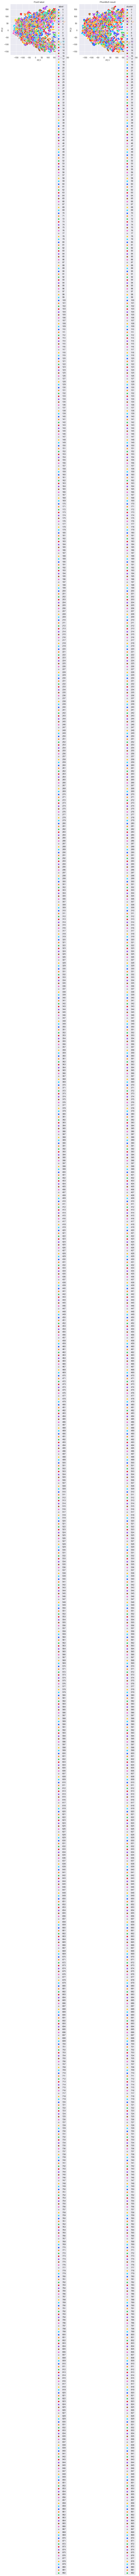

In [15]:
#Just for plotting purposes we use PCA and plot the data on two best features after PCA.
# Create clusters using Agglomerative hierarchical clustering#
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 883, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(pc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y, palette='bright', ax=ax1);
ax1.set(xlabel="PC1", ylabel="PC2", title="Pos9 label")
ax1.legend(title='label')

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y_cluster, palette='bright', ax=ax2);
ax2.set(xlabel="PC1", ylabel="PC2", title="PhonMo5 result")
ax2.legend(title='cluster');

## Normal Clustering using all the features

In [16]:
#Now we go back to data and use Scaling and do the Clustering on 512 features
scaled_data = StandardScaler(with_mean=False).fit_transform(data)
print(scaled_data.shape)

#Doing the clustering based on 512 features
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 883, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(scaled_data)

(8800, 115200)


In [17]:
#Let's see how the data looks like after clustering
data = pd.DataFrame(scaled_data)
pc_data = pd.DataFrame(data, columns=data.columns, index=data.index)
pc_data['cluster'] = y_cluster
pc_data['Words'] = np.array(full_generator.my_list)
pc_data = pc_data.set_index('Words')

pc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,115191,115192,115193,115194,115195,115196,115197,115198,115199,cluster
Words,,,,,,,,,,,,,,,,,,,,,
manageable-Ralph,-6.225603,-6.435580,-6.100837,1.814820,-4.464437,3.719873,2.825410,-3.572288,1.617152,1.170296,...,2.006720,-1.103963,0.000101,-0.064648,1.975652,1.546906,0.196145,0.657271,-0.000005,693
brighter-Victoria,-6.151953,-6.938196,-5.938293,3.701040,-5.390492,3.563632,2.637887,-1.447803,2.606675,2.540750,...,-0.312902,-1.291341,0.000160,-0.672624,1.736931,1.354933,0.007834,0.354610,0.000020,193
translating-Kathy,-6.070018,-7.911967,-5.940924,4.392559,-7.807117,2.901775,4.627062,0.341084,2.297652,4.050326,...,-0.305056,1.011602,0.000579,-0.102673,0.058728,-0.000402,0.963855,1.620412,-0.001262,402
actively-Agnes,-4.174591,-5.800267,-6.655507,3.274112,-5.442787,5.998799,1.051878,-2.706991,3.712942,1.681259,...,0.713811,-0.478852,0.001823,-1.318673,1.370881,0.347379,-1.452829,1.344866,-0.000226,434
passing-Alex,-6.246258,-7.031011,-6.059861,3.126461,-5.541393,3.651524,2.945796,-2.111565,1.862508,2.113343,...,-0.869074,1.070320,0.016624,-0.000239,2.271925,-1.796847,-1.709461,0.587511,-0.030448,557


In [18]:
#cluster counts
CC = np.bincount(y_cluster)
print ("Cluster Counts:", CC)
#true class counts
TC = np.bincount(y)
print ("True Label Counts:", TC)

Cluster Counts: [18 14 20 22 12  9 16 21 10 12 14 12 12 18 24 19 15 16 16 11 10 19 10  4
 20 13 11 18  9 21 20 10 11 18 12 13  9 11 10 12 11 10 13 11 19 13 10  9
 10 10 10 20  9  9 13 11 12  9 10 13 11 18 12 11 12  8 14 11 11 12  9 12
  9  9 11 10 21  7  5 10 19 12 10  9  9 10 11  9  9 10  9 12 11 11 11 11
  3  8  9 11 12  2 10 10  9 15  9 11  4 13  9  9  9 10 12  9 10 11  7 10
 12 11 10 18  9 11 10 10 11 12 10 12 10 10  9 13 11 10 13 12  9 20 11  9
 10 20 10 11  3 10  9 16 11 10 10 10 12  9 10 10 10  9 10  9 11 10 19  9
 11 13  9 11 10 12  9 12 10 10 12  9 12 10 10 10  9 12 11  9  9  9  9 11
 10  9 13 10 10  9 10  9  9  9  6 11 10 10  9  9  9 10 10  9 10  8  8  9
 10  9  3 10 10 10  8 10 10  8 11  9 10 10 11 10  9 12  9 10  9 11 11 11
 11 10 10 10 10  9 10  9 10 10  9 10 10 11 12 10 10 11 10  9 10 10 10  9
  9 10  9 10 11 10 10  9 10 10  9 12 10  9 11 10 10 10 13  9  8 10 10 11
 11 10  9  9 10 10 11  9  9 10  9  9 10 11 10 11 11 10  9 11 10 10 10 10
 10  9 10 10 11 11  9 10 10 10 11 1

In [19]:
# Find the size of the clusters
pc_data["cluster"].value_counts()

14     24
3      22
76     21
498    21
7      21
       ..
880     2
853     2
874     2
385     2
101     2
Name: cluster, Length: 883, dtype: int64

## Clustering performance evaluation

In [22]:
from sklearn import metrics
# labels_true = [0, 0, 0, 1, 1, 1]
# labels_pred = [0, 0, 1, 1, 2, 2]
labels_true = y
labels_pred = y_cluster

In [23]:
# Mutual Information based scores
print ("Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print ("Normalized Mutual Info:", metrics.normalized_mutual_info_score(labels_true, labels_pred))
print ("Adjusted Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
#Perfect labeling is scored 1.0, bad labeling have non-positive scores.

Mutual Info: 0.8885031479908869
Normalized Mutual Info: 0.962032813859016
Adjusted Mutual Info: 0.8885031479908869
